In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

## SETUP 1 - MODEL FREE learning

empirical test error tensor(0.3122) theoritical test error =  0.3123283970239778


<ipython-input-139-e39f7d351c17>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Btest = torch.tensor(np.matmul(A,Xtest.transpose(0,1)))


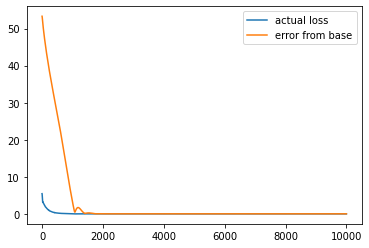

0.029469449073076248


In [139]:
d = 100 # dimension of data points x
n = 90 # number of data points
ntest = 10000
m = 100 # size of measurements b
noise = 0
X = np.random.uniform(-1/np.sqrt(d),1/np.sqrt(d),size = (n,d))
A = np.random.uniform(-1/np.sqrt(d),1/np.sqrt(d),(m,d))
B = np.matmul(A,X.T) 
B += noise*np.random.uniform(-1,1,size = B.shape)

Sigma = np.eye(d)/(3*d)

X = torch.tensor(X)
A = torch.tensor(A)
B = torch.tensor(B)

C = torch.zeros((d,m),requires_grad = True)

#cov = np.matmul(X.transpose(0,1),X)
estimateML = np.matmul(X.T, np.linalg.pinv(B))


optimizer = optim.SGD([C], lr = 0.1, momentum = 0.99)

epochs = 10000
l = []
lbase = []
for i in range(epochs):
    optimizer.zero_grad()
    loss = torch.norm(C.matmul(B.float()).transpose(0,1) - X.float())
    loss.backward()
    optimizer.step()
    l.append(loss.item())
    lbase.append(torch.norm(C.detach() - estimateML.float()))
def test(C):
    Xtest = torch.tensor(np.random.uniform(-1/np.sqrt(d),1/np.sqrt(d),size = (ntest,d)))
    Btest = torch.tensor(np.matmul(A,Xtest.transpose(0,1)))
    return torch.norm(C.matmul(Btest.float()).transpose(0,1)-Xtest.float())**2/ntest

testerror = np.matrix.trace(np.matmul(np.matmul(
        np.matmul(estimateML,A)-np.eye(d),
        Sigma),np.matmul(estimateML,A).T-np.eye(d)).numpy())#torch.norm(np.matmul(estimateML,A)-np.eye(d))**2/(3*d)
print('empirical test error', test(C.detach()), 'theoritical test error = ', testerror)
plt.plot(l,label = 'actual loss')

plt.plot(lbase,label = 'error from base')
plt.legend()
plt.show()
print(l[-1])

## SETUP 2 - MODEL BASED LEARNING with step-size learning

<ipython-input-129-e352c105fe5f>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Btest = torch.tensor(np.matmul(A,Xtest.transpose(0,1)))


tensor(0.1819)


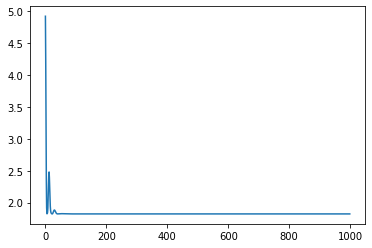

In [129]:
C = torch.ones((d,d),requires_grad = True)
eta = torch.tensor(1.0,requires_grad = True)
optimizer = optim.SGD([C,eta], lr = 0.01, momentum = 0.9)

epochs = 1000
l = []
for i in range(epochs):
    optimizer.zero_grad()
    
    #eta = 0.1
    temp = eta*A.transpose(0,1).matmul(B).float()
    temp1 = 2*torch.eye(d) - eta*A.transpose(0,1).matmul(A).float() - eta*C
    loss = torch.norm(temp1.matmul(temp) - X.transpose(0,1).float())
    loss.backward()
    optimizer.step()
    l.append(loss.item())
def test(C,eta):
    Xtest = torch.tensor(np.random.uniform(-1,1,size = (ntest,d)))
    Btest = torch.tensor(np.matmul(A,Xtest.transpose(0,1)))
    #eta = 0.1
    temp = eta*A.transpose(0,1).matmul(Btest).float()
    temp1 = 2*torch.eye(d) - eta*A.transpose(0,1).matmul(A).float() - eta*C
    return torch.norm(temp1.matmul(temp) - Xtest.transpose(0,1).float())/ntest

print(test(C.detach(),eta.detach()))
plt.plot(l)
plt.show()

## MODEL BASED LEARNING NOT LEARNING STEP-SIZE

tensor(0.8848)
test-set error tensor(0.8702) test one iter gd tensor(0.2936) test-error theoritical unroll tensor(0.8848, dtype=torch.float64)


<ipython-input-140-624ff090342d>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Btest = torch.tensor(np.matmul(A,Xtest.transpose(0,1)))


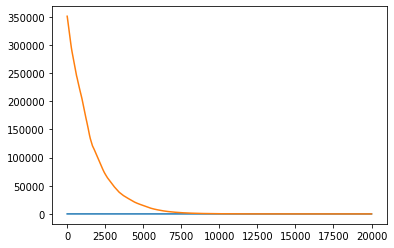

6.905156624270603e-08 tensor(0.0816, dtype=torch.float64)


In [140]:
C = torch.zeros((d,d),requires_grad = True)
eta = .1
optimizer = optim.SGD([C], lr = 10000, momentum = .999)

temp = torch.matmul(A.transpose(0,1),B)
ata = torch.matmul(A.transpose(0,1),A)
pred = torch.matmul(torch.matmul(eta*(2*torch.eye(d) - eta*ata),
                         torch.eye(d) - torch.matmul(temp,torch.linalg.pinv(temp))),
                    A.transpose(0,1)) + torch.matmul(torch.matmul(X.transpose(0,1),torch.linalg.pinv(temp)),
                                                  A.transpose(0,1))
Chat = torch.matmul(eta*(2*torch.eye(d) - eta*ata),
                         torch.matmul(temp,torch.linalg.pinv(temp)))- torch.matmul(X.transpose(0,1),torch.linalg.pinv(temp))
Chat /= eta**2


temp = eta*A.transpose(0,1)
temp1 = 2*torch.eye(d) - eta*A.transpose(0,1).matmul(A).float() - eta*Chat
Sigma = torch.eye(d)/(3*d)
print(torch.trace(torch.matmul(temp1.matmul(temp).matmul(A).transpose(0,1).float() - torch.eye(d),
                               Sigma.float()).matmul(temp1.matmul(temp).matmul(A).float() - torch.eye(d))) )


epochs = 20000
l = []
ltheoritical = []

for i in range(epochs):
    optimizer.zero_grad()
    
    temp = eta*A.transpose(0,1).matmul(B).float()
    temp1 = 2*torch.eye(d) - eta*A.transpose(0,1).matmul(A).float() - eta*C
    loss = torch.norm(temp1.matmul(temp) - X.transpose(0,1).float())**2
    loss.backward()
    optimizer.step()
    l.append(loss.item())
    ltheoritical.append( torch.norm(Chat-C.detach())**2/d**2 )
def test(C,eta, algorithm ):
    Xtest = torch.tensor(np.random.uniform(-1/np.sqrt(d),1/np.sqrt(d),size = (ntest,d)))
    Btest = torch.tensor(np.matmul(A,Xtest.transpose(0,1)))
    
    temp = eta*A.transpose(0,1).matmul(Btest).float()
    if algorithm == 'no learn':
        temp1 = 2*torch.eye(d) - eta*A.transpose(0,1).matmul(A).float()
    else:
        temp1 = 2*torch.eye(d) - eta*A.transpose(0,1).matmul(A).float() - eta*C
    return torch.norm(temp1.matmul(temp) - Xtest.transpose(0,1).float())**2/ntest

testerror = torch.norm( torch.matmul(pred,A)-torch.eye(d) )**2/(3*d)
print('test-set error', test(C.detach(),eta, 'learn'), 'test one iter gd', test(C.detach(),eta,'no learn'), 
      'test-error theoritical unroll', testerror)
plt.plot(l)
plt.plot(ltheoritical)
plt.show()
print(l[-1],ltheoritical[-1])

## MODEL BASED LEARNING 2 iterations

tensor(85.9057)


C:\Users\siddp\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


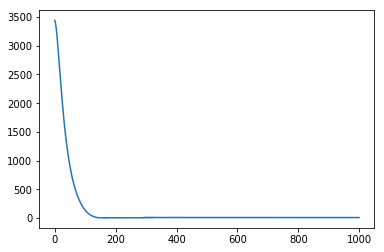

In [210]:
C = torch.ones((d,d),requires_grad = True)
C1 = torch.ones((d,d),requires_grad = True)
eta = .1
optimizer = optim.SGD([C,C1], lr = 0.01, momentum = 0.9)

epochs = 1000
l = []
for i in range(epochs):
    optimizer.zero_grad()
    
    temp = eta*A.transpose(0,1).matmul(B).float()
    temp1 = torch.eye(d) - eta*A.transpose(0,1).matmul(A).float() - eta*C
    temp2 = torch.eye(d) - eta*A.transpose(0,1).matmul(A).float() - eta*C1
    temp3 = (torch.eye(d) + temp1 + temp1.matmul(temp2)).matmul(temp)
    loss = torch.norm(temp3 - X.transpose(0,1).float())
    loss.backward()
    optimizer.step()
    l.append(loss.item())
def test(C,C1,eta):
    Xtest = torch.tensor(np.random.uniform(-1,1,size = (ntest,d)))
    Btest = torch.tensor(np.matmul(A,Xtest.transpose(0,1)))

    temp = eta*A.transpose(0,1).matmul(Btest).float()
    temp1 = torch.eye(d) - eta*A.transpose(0,1).matmul(A).float() - eta*C
    temp2 = torch.eye(d) - eta*A.transpose(0,1).matmul(A).float() - eta*C1
    temp3 = (torch.eye(d) + temp1 + temp1.matmul(temp2)).matmul(temp)
    loss = torch.norm(temp3 - Xtest.transpose(0,1).float())/ntest
    return loss

print(test(C.detach(),C1.detach(),eta))
plt.plot(l)
plt.show() 

## Theoritical bounds

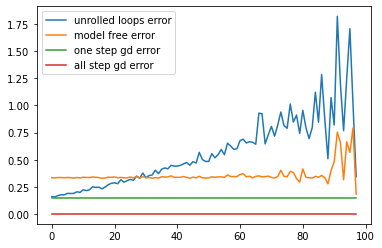

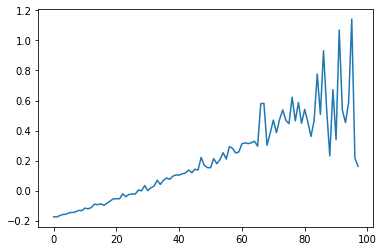

In [137]:
unroll = []
modelfree = []
onestepgd = []
d = 100 # dimension of data points x
m = 100 # size of measurements b
#sigma = np.linspace(0.0001,1,d)
Sigma = np.eye(d)/(3*d)#np.random.uniform(0,1,size = (d,d))#np.diag(sigma)
A = np.random.uniform(-1/np.sqrt(d),1/np.sqrt(d),(m,d))
eta = 1
ata = np.matmul(A.T,A)
for n in range(2,100):
    X = np.random.uniform(-1/np.sqrt(d),1/np.sqrt(d),size = (n,d))#np.random.binomial(size=(n,d), n=1, p= 0.1)#np.random.uniform(-1/np.sqrt(d),1/np.sqrt(d),size = (n,d))##
    cov = np.matmul(X.T,X)
    B = np.matmul(A,X.T)
    #estimateUL = np.matmul(np.matmul(cov,ata), 
    #                       np.linalg.pinv(np.matmul(np.matmul(A,cov),ata)))
    
    ##atacovata = np.matmul(np.matmul(ata,cov),ata)
    ##covataInvatacovata = np.matmul(np.matmul(cov,ata),
    ##                               np.linalg.pinv(atacovata,hermitian = True))
    
    ##atacovataInvatacovata = np.matmul(atacovata,
    ##                               np.linalg.pinv(atacovata,hermitian = True))
    ###etaeyeataat = np.matmul(eta*(2*np.eye(d) - eta*ata), A.T) 
    ##covataInvatacovataat =  np.matmul(covataInvatacovata,A.T)
    
    ##etaeyeataatacovataInvatacovataat = np.matmul(np.matmul(
    ##                                eta*(2*np.eye(d) - eta*ata), 
    ##                            np.eye(d) - atacovataInvatacovata),A.T)
    ##estimateUL =  covataInvatacovataat 
    ##+ etaeyeataatacovataInvatacovataat
    
    temp = np.matmul(A.T,B)
    ata = np.matmul(A.T,A)
    estimateUL = np.matmul(np.matmul(eta*(2*np.eye(d) - eta*ata),
                         np.eye(d) - np.matmul(temp,np.linalg.pinv(temp))),
                    A.T) + np.matmul(np.matmul(X.T,np.linalg.pinv(temp)), A.T)


    
    
    
    #print(sum(np.diag(atacovataInvatacovata)) )
    #plt.figure(n)
    #plt.imshow(atacovataInvatacovata)
    #plt.show()
    estimateML = np.matmul(X.T, np.linalg.pinv(B))
    #np.matmul(np.matmul(cov,A.T), np.linalg.pinv(np.matmul(np.matmul(A,cov),A.T)))
    
    ULerror = np.matrix.trace(np.matmul(np.matmul(
        np.matmul(estimateUL,A)-np.eye(d),Sigma),
                                        np.matmul(estimateUL,A).T-np.eye(d)))
    
    MLerror = np.matrix.trace(np.matmul(np.matmul(
        np.matmul(estimateML,A)-np.eye(d),
        Sigma),np.matmul(estimateML,A).T-np.eye(d)))
    
    #ULerror = np.linalg.norm( np.matmul(pred,A)-np.eye(d) )**2/(3*d)
    unroll.append(ULerror)
    modelfree.append(MLerror)
estimateonestepgd = np.matmul(eta*(2*np.eye(d) - eta*ata), A.T)
gdonesteperror = np.matrix.trace(np.matmul(np.matmul(
        np.matmul(estimateonestepgd,A)-np.eye(d),Sigma),
                    np.matmul(estimateonestepgd,A).T-np.eye(d)))    
onestepgd = [gdonesteperror]*len(unroll)
allstepgd = [ np.matrix.trace(np.matmul(
    np.matmul(np.linalg.pinv(A),A)-np.eye(d),
    np.matmul(np.linalg.pinv(A),A).T-np.eye(d))) ]*len(onestepgd)
plt.plot(unroll,label = 'unrolled loops error')
plt.plot(modelfree, label = 'model free error')
plt.plot(onestepgd, label = 'one step gd error')
plt.plot(allstepgd,label = 'all step gd error')
plt.legend()
plt.show()
plt.plot(np.array(unroll)-np.array(modelfree))